In [1]:
# The strategy is straightforward:
# if any asset grows 1% within an hour, then buy, set TP +2% and SL -2%

# video tutorial: https://www.youtube.com/watch?v=XA5EI0rmYeA
# @Algovibes youtube channel

In [ ]:
# This strategy worked on BTC , but failed on ETH, LINK and ADA  !!!
# Probably, because these altcoins are more volatile and 1% increase does not mean as much
# as in BTC case. In altcoins case it is normal volatility and after 1% increase
# it is usually rolling back   -2%

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client

In [2]:
client = Client()

In [4]:
def getdata(symbol, start, end = '2023-08-24'):
    frame = pd.DataFrame(client.get_historical_klines(symbol, '1h', start, end))
    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame.set_index('Time', inplace=True)
    frame.index = pd.to_datetime(frame.index, unit='ms')
    frame = frame.astype(float)
    return frame

In [142]:
# symbol = 'BTCUSDT'
symbol = 'ETHUSDT'
start = '2023-01-01'

# end = '2023-01-01'
df = getdata(symbol, start)

In [143]:
df

,Open,High,Low,Close,Volume
Time,,,,,
2023-01-01 00:00:00,1196.13,1196.70,1192.72,1194.09,5889.3840
2023-01-01 01:00:00,1194.09,1196.37,1193.84,1196.02,3157.2079
2023-01-01 02:00:00,1196.01,1196.74,1194.11,1195.40,3752.0476
2023-01-01 03:00:00,1195.41,1195.41,1191.71,1194.04,7493.4207
2023-01-01 04:00:00,1194.05,1194.05,1190.57,1192.92,6409.2491
...,...,...,...,...,...
2023-08-23 20:00:00,1687.20,1692.78,1679.73,1684.51,18091.6350
2023-08-23 21:00:00,1684.50,1685.56,1660.00,1665.26,14285.1407
2023-08-23 22:00:00,1665.26,1678.79,1664.22,1676.19,11651.4788


In [144]:
# Calculate hourly return on close prices
df['ret'] = df.Close.pct_change()

In [145]:
# df

In [129]:
# Optional step: analyzing percentage return
# df.ret.plot(kind='hist', bins=100)

In [146]:
df['price'] = df.Open.shift(-1)   # we can buy only at the Open price of the next candle

In [147]:
# df

In [148]:
# the strategy itself, looping through the above dataframe

take_profit = 1.02
stop_loss = 0.98

trend_signal = 0.01  # buy if 1% growth

in_position = False
profits = []

for index, row in df.iterrows():
    if not in_position:
        if row.ret > trend_signal:
            buyprice = row.price
            bought_at = index
            tp = buyprice * take_profit
            sl = buyprice * stop_loss
            in_position = True
    if in_position and index > bought_at:
        if row.High > tp:
            profit = (take_profit - 1) #- 0.0015  # subtracting Binance comission 0.15%
            if symbol != 'BTCUSDT':
                profit -= 0.0015
            profits.append(profit)
            in_position = False
        if row.Low < sl and index > bought_at:
            profit = (stop_loss - 1) # - 0.0015
            if symbol != 'BTCUSDT':
                profit -= 0.0015
            profits.append(profit)
            in_position = False
            

In [149]:
pd.Series(profits)
(pd.Series(profits) > 0).value_counts()

False    47
True     46
Name: count, dtype: int64

In [150]:
(pd.Series(profits) > 0).value_counts()

False    47
True     46
Name: count, dtype: int64

In [151]:
(pd.Series(profits) + 1).prod()

0.8366937852795169

<Axes: >

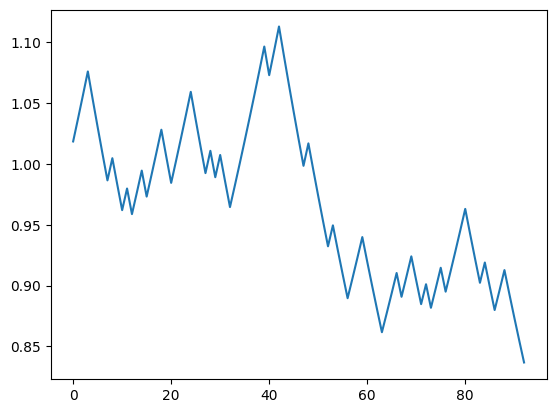

In [152]:
(pd.Series(profits) + 1).cumprod().plot()